## Determine Circle segments

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import numpy.ma as ma

import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from datetime import datetime

### User input for circle selection

In [2]:
flightID = "HALO-20240916a"

bahamasFreq            = 100              # Hz
resamplingTime         =  30              # in seconds [interpolation/averaging interval of raw data]
minimumTimeForStraight = 1800*bahamasFreq # in seconds times bahamas freq
guessRange             = 4                # resampling intervalls before and after the estimated guess

trackResampling        = 1 # resamplingTime*bahamasFreq


### Open file

In [3]:
ds = xr.open_zarr("ipns://latest.orcestra-campaign.org/products/HALO/position_attitude/"+flightID+".zarr")

### Full flight track

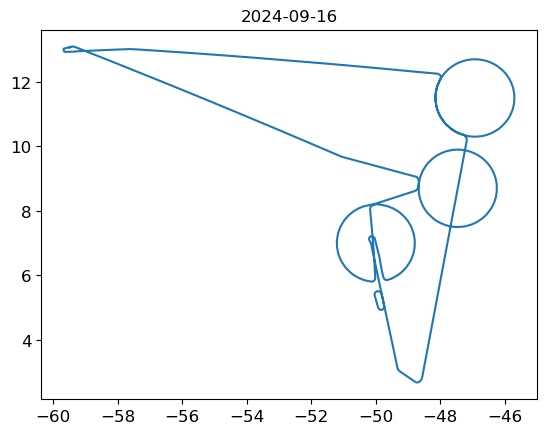

In [4]:
fig = plt.figure()
ax = fig.add_subplot()

plt.xticks(fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

ax.plot(ds.lon,ds.lat)

plt.title(f"{pd.Timestamp(ds.time.values[0]).to_pydatetime():%Y-%m-%d}")
plt.show()

### Flight altitude difference

[5.7128 5.7129 5.7131 ... 8.0485 8.0484 8.0483]


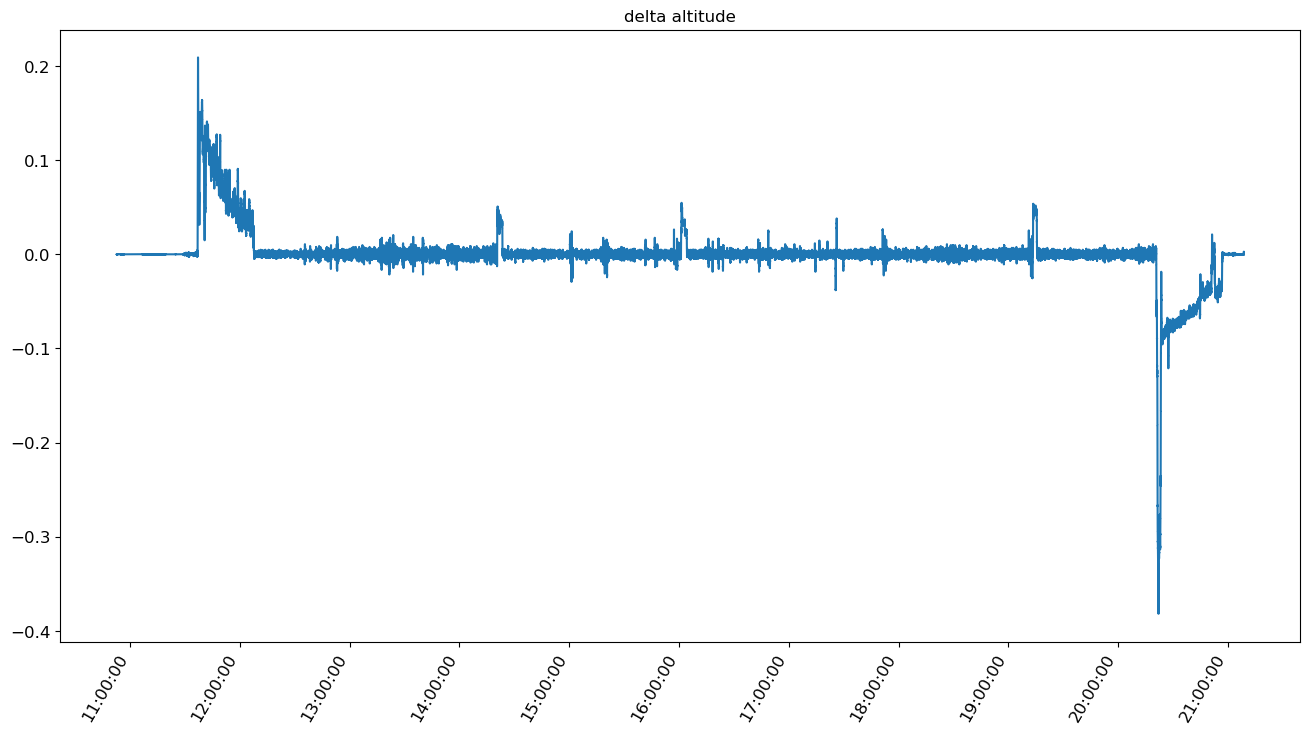

In [5]:
deltaalt = np.diff(ds.alt,n=1)
deltaalt = np.insert(deltaalt,0,0)

print (ds.alt.values)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

resamplingTimeStr= str(resamplingTime)+'s'
ax.plot(ds.time,deltaalt)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.title("delta altitude")
plt.show()

### Delta flight heading

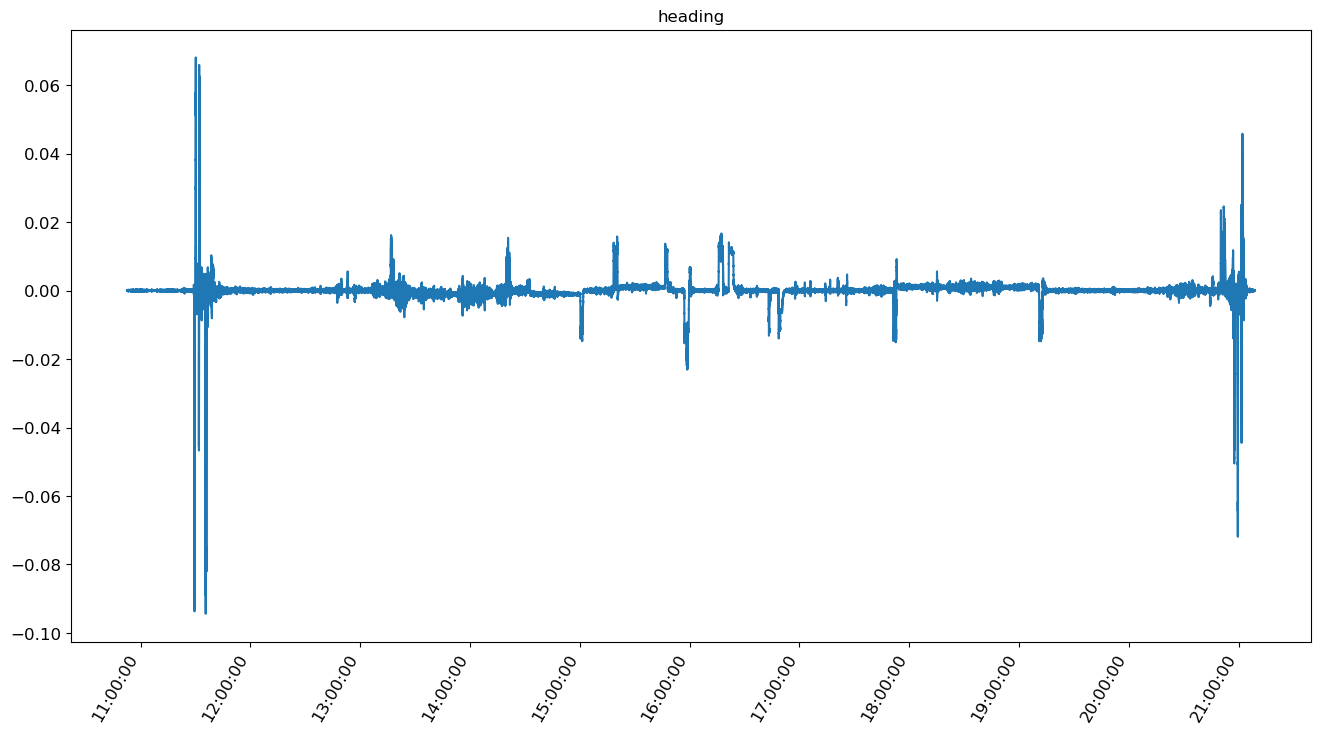

In [6]:
deltahead = np.diff(ds.heading,n=1)
deltahead = np.insert(deltahead,0,0)
deltahead = np.where( (deltahead >  359) , deltahead-360, deltahead)
deltahead = np.where( (deltahead < -359) , deltahead+360, deltahead)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(ds.time,deltahead)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)

plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.title("heading")

plt.show()

### Flight roll

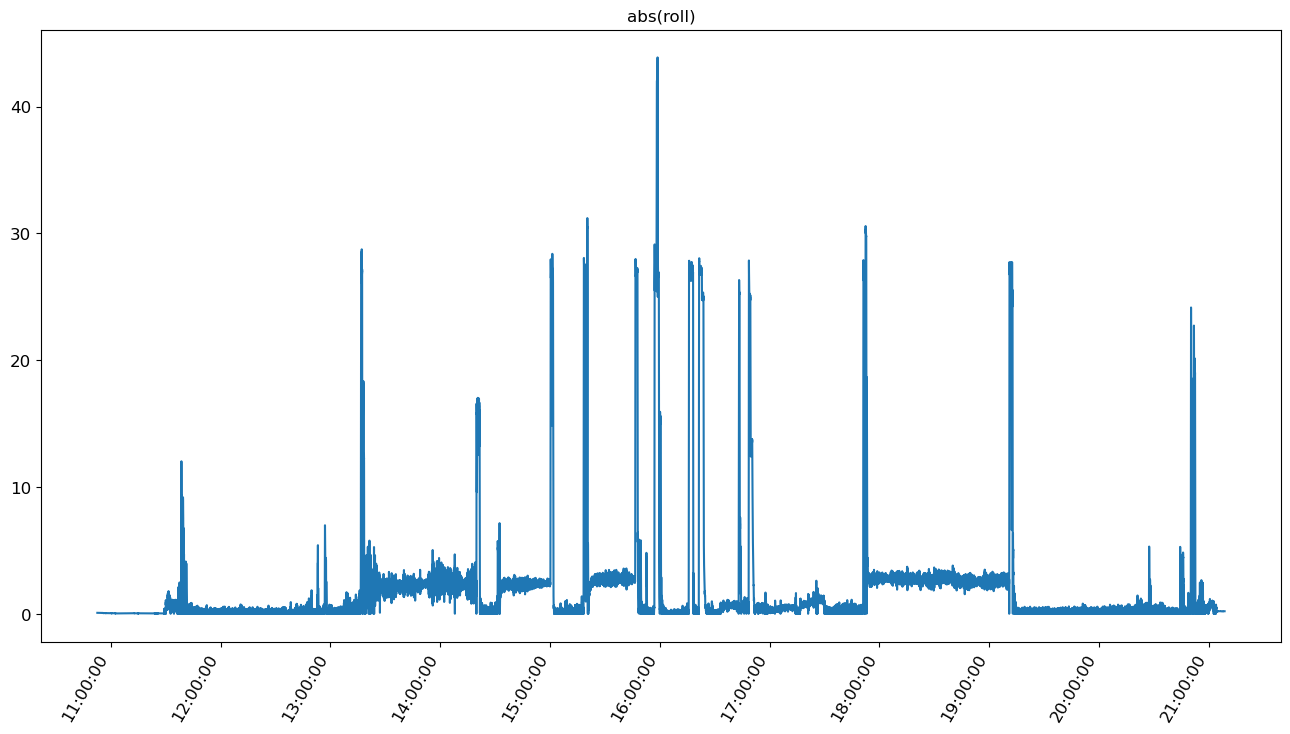

In [7]:
roll = abs(ds['roll'])

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(roll.time,roll)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.title("abs(roll)")
plt.show()

### Now get to the lines

In [8]:
smin=-0.004
smax= 0.004

straight = np.ma.masked_where( ( deltahead < smin ) | ( deltahead > smax ) | ( ds.alt < 10 ) & ( roll < 0.5 ), deltahead )
slices = np.ma.flatnotmasked_contiguous(straight)

slices_start = np.array([s.start for s in slices])
slices_end   = np.array([s.stop  for s in slices])

j=0
segment=0
for i in slices_start:
    ibeg=i
    iend=slices_end[j]
    straight_length = iend-ibeg+1
    j += 1

    straight_start = ds.time[ibeg]
    straight_stop  = ds.time[iend]

    if ( straight_length <= minimumTimeForStraight ) :
        for index in range(ibeg, iend):
            straight.mask[index] = True
    else :
        print (pd.Timestamp(straight_start.time.values).to_pydatetime() , " to ", pd.Timestamp(straight_stop.time.values).to_pydatetime())
        segment += 1 

2024-09-16 11:39:44.309000  to  2024-09-16 12:53:06.539000
2024-09-16 14:21:47.200000  to  2024-09-16 15:00:16.090000
2024-09-16 16:50:42.330000  to  2024-09-16 17:25:31.470000
2024-09-16 18:15:09.450000  to  2024-09-16 19:10:58.050000
2024-09-16 19:12:49.940000  to  2024-09-16 20:44:19.690000


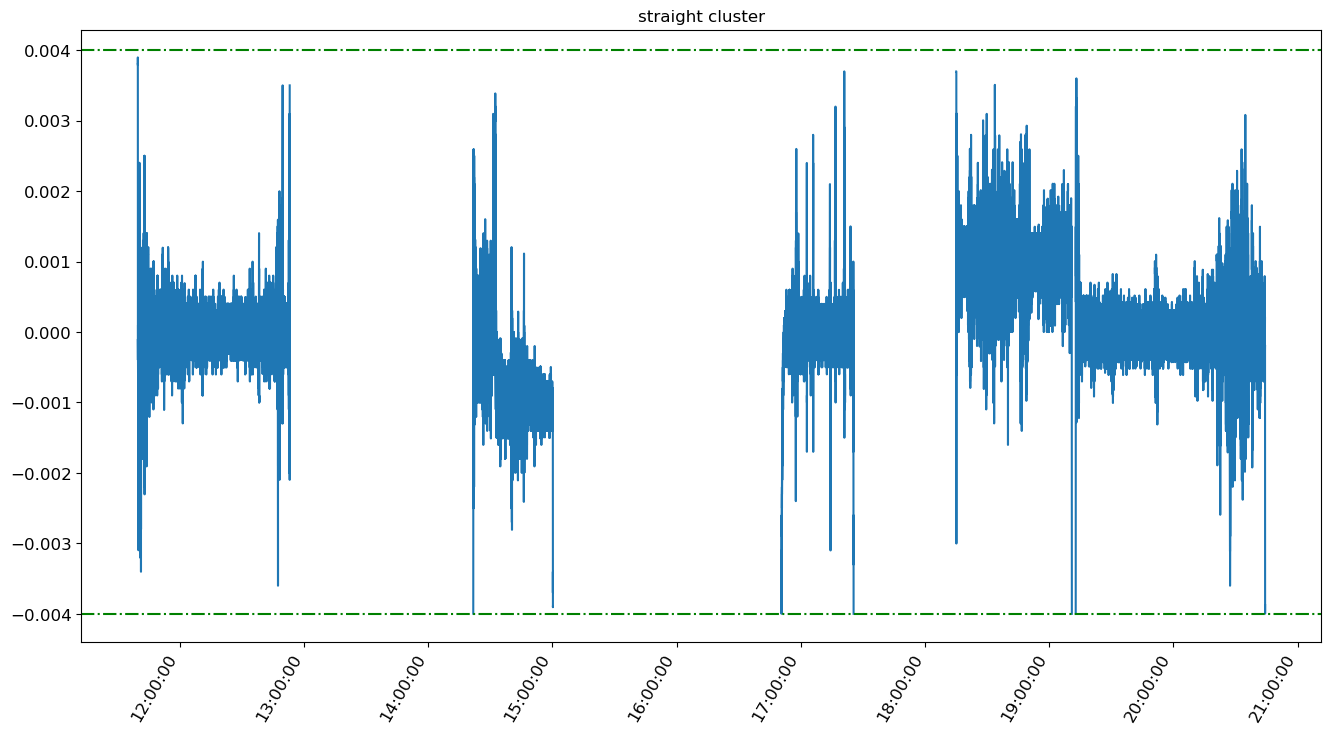

In [9]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(ds.time,straight)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.axhline(y=smax, color='g', linestyle='-.')
plt.axhline(y=smin, color='g', linestyle='-.')

plt.title("straight cluster")
plt.show()

### Start of straight line

2024-09-16 11:39:44.309000  to  2024-09-16 12:53:06.539000
2024-09-16 14:21:47.200000  to  2024-09-16 15:00:16.090000
2024-09-16 16:50:42.330000  to  2024-09-16 17:25:31.470000
2024-09-16 18:15:09.450000  to  2024-09-16 19:10:58.050000
2024-09-16 19:12:49.940000  to  2024-09-16 20:44:19.690000


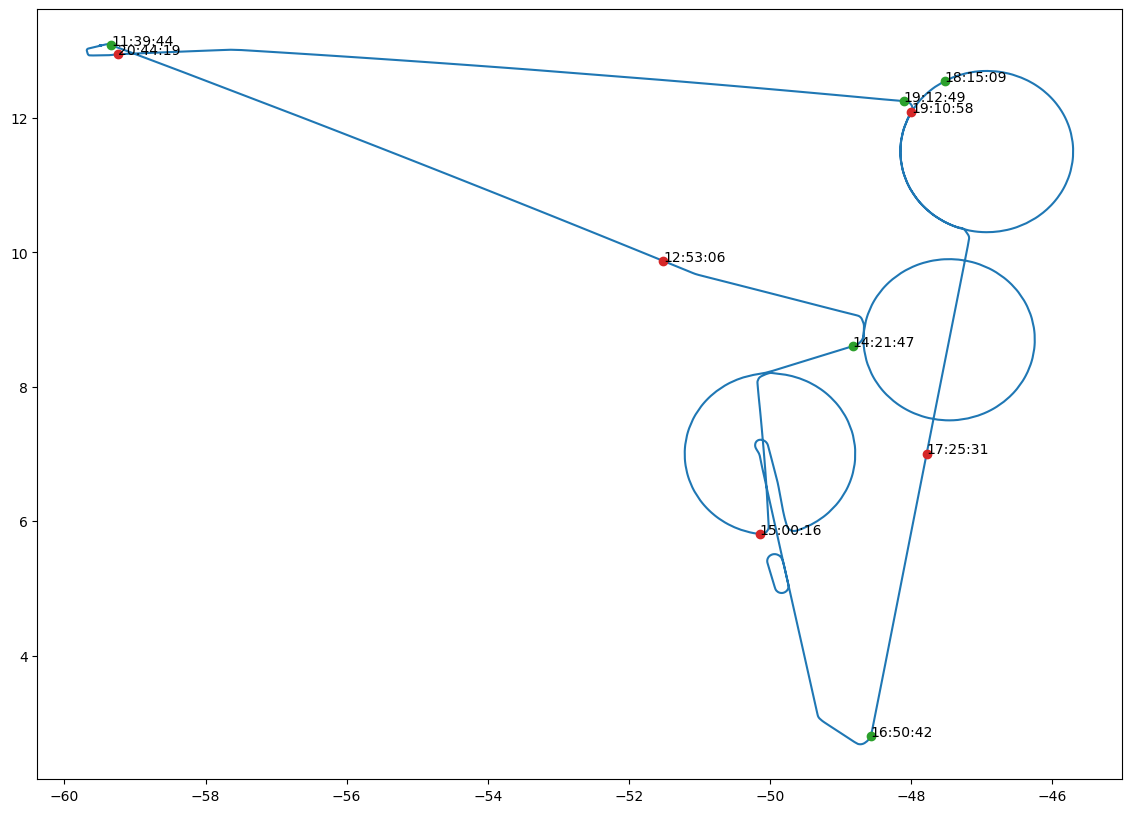

In [12]:
j=0
guessRange=0

minlat = np.min(ds.lat.values)
maxlat = np.max(ds.lat.values)
minlon = np.min(ds.lon.values)
maxlon = np.max(ds.lon.values)

xs=round(maxlon-minlon)
ys=round(maxlat-minlat)

fig = plt.figure(figsize=(xs,ys))
ax = fig.add_subplot()

ax.plot(ds.lon, ds.lat)

for i in slices_start:

    ibeg=i
    iend=slices_end[j]

    straight_length = iend-ibeg+1
    straight_start_bef = ds.time[ibeg-guessRange]
    straight_start_mid = ds.time[ibeg]
    straight_start_aft = ds.time[ibeg+guessRange]

    straight_end_bef = ds.time[iend-guessRange]
    straight_end_mid = ds.time[iend]
    straight_end_aft = ds.time[iend+guessRange]

    if ( straight_length > minimumTimeForStraight ) :

        print (pd.Timestamp(straight_start_mid.time.values).to_pydatetime() , " to ",
               pd.Timestamp(straight_end_mid.time.values).to_pydatetime())

        point_start_bef = ds.isel(time=((ibeg-guessRange)*trackResampling))
        point_start_mid = ds.isel(time=( ibeg            *trackResampling))
        point_start_aft = ds.isel(time=((ibeg+guessRange)*trackResampling))

        ax.scatter(point_start_mid.lon, point_start_mid.lat, color="tab:green", zorder=3)
        ax.text   (point_start_mid.lon, point_start_mid.lat, f"{pd.Timestamp(straight_start_mid.time.values).to_pydatetime():%H:%M:%S}")

        point_end_bef = ds.isel(time=((iend-guessRange)*trackResampling))
        point_end_mid = ds.isel(time=( iend            *trackResampling))
        point_end_aft = ds.isel(time=((iend+guessRange)*trackResampling))

        ax.scatter(point_end_mid.lon, point_end_mid.lat, color="tab:red", zorder=3)
        ax.text   (point_end_mid.lon, point_end_mid.lat, f"{pd.Timestamp(straight_end_mid.time.values).to_pydatetime():%H:%M:%S}")

        segment += 1

    j += 1

plt.show()

In [ ]:
for i in slices_start:

    ibeg=i
    iend=slices_end[j]

    straight_length = iend-ibeg+1
    straight_start_bef = ds.time[ibeg-guessRange]
    straight_start_mid = ds.time[ibeg]
    straight_start_aft = ds.time[ibeg+guessRange]

    straight_end_bef = ds.time[iend-guessRange]
    straight_end_mid = ds.time[iend]
    straight_end_aft = ds.time[iend+guessRange]

    if ( straight_length > minimumTimeForStraight ) :

        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot()

        ax.plot(ds.time,straight)

        timeFmt = DateFormatter("%H:%M:%S")
     ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.axhline(y=smax, color='g', linestyle='-.')
plt.axhline(y=smin, color='g', linestyle='-.')

plt.title("straight cluster")
plt.show()